Imports and load models

In [1]:
#pip install transformers[sentencepiece]

import sklearn
from sklearn.datasets import load_files
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import zipfile
import spacy
import re
import torch
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

# Load Aspect-Based Sentiment Analysis model
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# Load a traditional Sentiment Analysis model
sentiment_model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_path,
                          tokenizer=sentiment_model_path)

c:\Users\david\Documents\GitHub\TNM108\Project\venv\lib\site-packages\transformers\convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Example for how the code works


In [ ]:
sentence = "TRUMP is YOUR president. show some love and leave the hate to Hillary."
print(f"Sentence: {sentence}")
print()

aspect = "Trump"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()

# ABSA of "service"
aspect = "Hillary"
inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
outputs = absa_model(**inputs)
probs = F.softmax(outputs.logits, dim=1)
probs = probs.detach().numpy()[0]
print(f"Sentiment of aspect '{aspect}' is:")
for prob, label in zip(probs, ["negative", "neutral", "positive"]):
  print(f"Label {label}: {prob}")
print()
# Sentiment of aspect 'service' is:
# Label negative: 0.9946129322052002
# Label neutral: 0.002369985682889819
# Label positive: 0.003017079783603549

# Overall sentiment of the sentence
sentiment = sentiment_model([sentence])[0]
print(f"Overall sentiment: {sentiment['label']} with score {sentiment['score']}")
# Overall sentiment: Negative with score 0.7706006765365601

Sentence: We had a great experience at the restaurant, food was delicious, but the service was kinda bad

Sentiment of aspect 'food' is:
Label negative: 0.000998911913484335
Label neutral: 0.0018238150514662266
Label positive: 0.997177243232727

Sentiment of aspect 'service' is:
Label negative: 0.9946129322052002
Label neutral: 0.0023699868470430374
Label positive: 0.003017081180587411

Overall sentiment: negative with score 0.7706007361412048


Function for analysing sentiment of different aspects 

In [34]:
# def analyze_aspects_sentiment(sentence, aspects, absa_tokenizer, absa_model):
#     for aspect in aspects:
#         # Tokenize the input
#         inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
        
#         # Get the model outputs
#         outputs = absa_model(**inputs)
        
#         # Apply softmax to obtain probabilities
#         probs = F.softmax(outputs.logits, dim=1)
#         probs = probs.detach().numpy()[0]  # Convert tensor to numpy array
        
#         # Print the sentiment probabilities
#         print(f"Sentiment of aspect '{aspect}' is:")
#         for prob, label in zip(probs, ["negative", "neutral", "positive"]):
#             print(f"  {label.capitalize()}: {prob:.4f}")
#         print()  # Add a newline for better readability
import torch.nn.functional as F

def analyze_aspects_sentiment(sentence, aspects, absa_tokenizer, absa_model, sentiment_model):
    sentiment_results = {}

    # Analyze sentiment for each aspect (e.g., food, service)
    for aspect in aspects:
        if aspect.lower() not in sentence.lower():
            #print(f"Aspect '{aspect}' not found in the sentence.")
        
            # Assign neutral sentiment when aspect is not found
            sentiment_results[aspect] = {
                "negative": 0.0,
                "neutral": 0.001,  # Fully neutral
                "positive": 0.0
            }
            continue  # Skip sentiment analysis for this aspect
        inputs = absa_tokenizer(f"[CLS] {sentence} [SEP] {aspect} [SEP]", return_tensors="pt")
        outputs = absa_model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        probs = probs.detach().numpy()[0]
        
        # Format aspect sentiment result
        sentiment_results[aspect] = {
            "negative": probs[0],
            "neutral": probs[1],
            "positive": probs[2]
        }

        # Print the sentiment of the aspect in the requested format
        #print(f"Sentiment of aspect '{aspect}' is:")
        #for label, prob in sentiment_results[aspect].items():
        #    print(f"Label {label}: {prob}")
        #print()

    # Overall sentiment of the sentence
    sentiment = sentiment_model([sentence])[0]
    #print(f"Overall sentiment: {sentiment['label']} with score {sentiment['score']}")

    return sentiment_results

Load dataset

In [6]:
# Load the CSV file
file_path = 'election_day_tweets_data/election_day_tweets.csv' 
elections_2016 = pd.read_csv(file_path)

elections_2016.sort_values(by='created_at').info()

<class 'pandas.core.frame.DataFrame'>
Index: 397629 entries, 162840 to 92778
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   text                           397629 non-null  object 
 1   created_at                     397629 non-null  object 
 2   geo                            2564 non-null    object 
 3   lang                           397629 non-null  object 
 4   place                          30832 non-null   object 
 5   coordinates                    2564 non-null    object 
 6   user.favourites_count          397629 non-null  int64  
 7   user.statuses_count            397629 non-null  int64  
 8   user.description               353403 non-null  object 
 9   user.location                  302677 non-null  object 
 10  user.id                        397629 non-null  int64  
 11  user.created_at                397629 non-null  object 
 12  user.verified                  

Preprocess tweets

In [7]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        #t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = re.sub(r"#", "", t)
        t = re.sub(r"#", "", t)  # Remove only the '#' symbol
        #t = 'http' if t.startswith('http') else t
        #remove links (URLs)
        t = re.sub(r'http\S+|www\S+|https\S+', '', t)
        new_text.append(t)
        t = t.lower().strip()

    return " ".join(new_text)

Test on some tweets:

In [18]:
# Set pandas display options to show the full content of cells
pd.set_option('display.max_colwidth', None)  # Show full text in columns
pd.set_option('display.max_rows', None)  # Optional: Show all rows if needed

elections_2016['text'] = elections_2016['text'].str.lower()  # Convert to lowercase
print(elections_2016['text'].head())
# Apply the cleaning function to the 'text' column
elections_2016['cleaned_text'] = elections_2016['text'].apply(preprocess)
print(elections_2016[['cleaned_text']].head())
# Define specific words to search for
specific_words = ['hillary', 'clinton']
our_specific_words = ['hillary', 'clinton', 'trump']

# Combine the words into a single regular expression pattern
pattern = '|'.join(rf'\b{word}\b' for word in specific_words)  # Matches whole words only
pattern2 = '|'.join(rf'\b{word}\b' for word in our_specific_words)  # Matches whole words only

# Filter rows where the cleaned text contains any of the specific words
trump_tweets = elections_2016[elections_2016['cleaned_text'].str.contains('trump', case=False, na=False)].copy()
hillary_tweets = elections_2016[elections_2016['cleaned_text'].str.contains(pattern, flags=re.IGNORECASE, na=False)].copy()
interesting_tweets = elections_2016[elections_2016['cleaned_text'].str.contains(pattern2, flags=re.IGNORECASE, na=False)].copy()
# Save the filtered results
#filtered_elections_2016.to_csv('filtered_words2.csv', index=False)

# Display example Hillary Tweets
print("Example Hillary Tweets:")
print(hillary_tweets[['cleaned_text']].head())  # Show the first 5 tweets related to Hillary

# Display example Trump Tweets
print("\nExample Trump Tweets:")
print(trump_tweets[['cleaned_text']].head())  # Show the first 5 tweets related to Trump


0      .@lawrence @hillaryclinton two first  @senschumer tomorrow. @thelastword #brooklyn  therealamerica #vote #democrats #nastywomenvote #senate
1    my @latimesopinion op-ed on historic #california #senate race. first time an elected woman senator succeeds another.\nhttps://t.co/cbjqtk0q1v
2                                        #senate wisconsin senate preview: johnson vs. feingold, the sequel https://t.co/xhq4p0v4el @senronjohnson
3           if rubio wins and #trump loses in #florida... #hillaryclinton #senate #republicanprimary #senaterace #miami... https://t.co/zienecvnmo
4                                #senate wisconsin senate preview: johnson vs. feingold, the sequel https://t.co/vsd6arfme5 senronjohnson nta•news
Name: text, dtype: object
                                                                                                                             cleaned_text
0  .@lawrence @hillaryclinton two first  @senschumer tomorrow. @thelastword brooklyn  therealamerica 

Actual test:
det är all_keywords som körs


In [35]:
# Define keywords
trump_keywords = ["trump"]
hillary_keywords = ["hillary", "clinton"]
all_keywords = ["trump", "hillary", "clinton"]

# Sample 10 tweets for Trump and Hillary
trump_tweets_sample = trump_tweets.sample(10)  # Random 10 samples
hillary_tweets_sample = hillary_tweets.sample(10)
interesting_tweets_sample = interesting_tweets.sample(10)

# Apply keyword-specific sentiment analysis
# print("Trump tweets and sentiment")
# for _, tweet in trump_tweets_sample.iterrows():  # Use iterrows to loop over rows
#     print(f"Tweet: {tweet['cleaned_text']}")
#     sentiment_results_trump = analyze_aspects_sentiment(
#         tweet['cleaned_text'], trump_keywords, absa_tokenizer, absa_model, sentiment_model
#     )
#     print()

# print("Hillary tweets and sentiment")
# for _, tweet in hillary_tweets_sample.iterrows():  # Use iterrows to loop over rows
#     print(f"Tweet: {tweet['cleaned_text']}")
#     sentiment_results_hillary = analyze_aspects_sentiment(
#         tweet['cleaned_text'], hillary_keywords, absa_tokenizer, absa_model, sentiment_model
#     )
#     print()

# Apply keyword-specific sentiment analysis
print("Overall tweets and sentiment")
for _, tweet in interesting_tweets_sample.iterrows():  # Use iterrows to loop over rows
    print(f"Tweet: {tweet['cleaned_text']}")
    sentiment_results_tweets = analyze_aspects_sentiment(
        tweet['cleaned_text'], all_keywords, absa_tokenizer, absa_model, sentiment_model
    )
    print()

Overall tweets and sentiment
Tweet: trump can't create any laws until 2 years into his presidency if he wins and laws have to go through congress

Tweet: hillary or hitler?  election2016

Tweet: trump could make a decision .. his members of congress gon agree with it .. but the states still have to ratify it

Tweet: @tiaanfaith i wouldn't worry to much . trump can't do anything without congress approval. mike pence has me more worried tbh.

Tweet: @lindseygrahamsc as a democrat and hillary voter, i sincerely appreciate your integrity. @evan_mcmullin is a fine choice for principled gop

Tweet: obama: "vote 4 trump is a vote to reverse all i have done in the last 8 years"
best endorsement for trump!!!… 

Tweet: dear democrat party. remember when we were all saying 'bernie is the only guaranteed way to beat trump'......................?

Tweet: carl rove said that paul ryan helped trump win wisconsin!! i'm sorry but that is just bullsh!t!!! 

Tweet: the clinton campaign just joined the ma

In [36]:
import pandas as pd

# Define a function to extract the dominant sentiment for an aspect
def get_dominant_sentiment(sentiment_results, aspect):
    aspect_sentiment = sentiment_results.get(aspect, {"positive": 0, "neutral": 0, "negative": 0})
    return max(aspect_sentiment, key=aspect_sentiment.get)

# Analyze sentiment and store results
hillary_sentiments = []
trump_sentiments = []

for _, tweet in interesting_tweets.iterrows():
    sentiment_results = analyze_aspects_sentiment(
        tweet["cleaned_text"], all_keywords, absa_tokenizer, absa_model, sentiment_model
    )
    hillary_sentiments.append(get_dominant_sentiment(sentiment_results, "Hillary"))
    trump_sentiments.append(get_dominant_sentiment(sentiment_results, "Trump"))

# Add sentiment columns to the DataFrame
interesting_tweets_sample["hillary_sentiment"] = hillary_sentiments
interesting_tweets_sample["trump_sentiment"] = trump_sentiments

# Save the updated DataFrame to a CSV file
output_file = "tweets_with_sentiment.csv"
interesting_tweets_sample.to_csv(output_file, index=False)

print(f"Saved sentiment analysis results to {output_file}")


KeyboardInterrupt: 

# TODO:
## **Create map visualization**
Typ ladda amerikansk karta, 

sortera bort tweets från utanför USA, placera ut tweets på karta

Röda för pro trump/anti hillary

Blå för pro hillary/anti trump

grå annars

**Sen typ räkna på procent av tweets i staten för att kunna jämföra med slutresultat**

Test för att läsa se om den kan sätta ut en punkt i rätt stat.

In [10]:
import os
import geopandas as gpd
from shapely.geometry import Point

# Define the path to the shapefile
shapefile_path = os.path.join("tl_2024_us_state", "tl_2024_us_state.shp")

# Load the shapefile into a GeoDataFrame
states = gpd.read_file(shapefile_path)

# Create a Point object for the coordinates (longitude, latitude)
point = Point(-108.370998, 42.228989)


# Check if the point is in any state
state = states[states.contains(point)]

if not state.empty:
    print(f"The point is in {state.iloc[0]['NAME']}")
else:
    print("The point is not within any US state.")

The point is in Wyoming


C:\Users\david\AppData\Local\Temp\ipykernel_8604\3280371108.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_with_coords['coordinates'] = tweets_with_coords['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
C:\Users\david\AppData\Local\Temp\ipykernel_8604\3280371108.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_with_coords['coordinates_set'] = tweets_with_coords['coordinates'].apply(


2370           (18.42712, -34.13787)
24142            (-71.4516, 42.9863)
28101            (-104.949, 39.7321)
35791    (-87.49761934, 33.17435814)
45924        (79.8580779, 7.0739524)
Name: coordinates_set, dtype: object
                                                                                                                                        text  \
2370   if clinton could have her way just to spite her she would move a motion to congress having the secret ballot stripped from americans.   
24142                4th election is in the books.\n#voted #vote #clinton #trump #nh #senate #governor #republicans… https://t.co/nsreubk0lf   
28101               captain america is on the streets of denver! he's a trump voter as well! @ congress park, denver https://t.co/ldbdofnzxh   
35791             @ewrobinson1 @zblox that’s been my thought. i’d be worried that a trump presidency would cede control of congress in 2018.   
45924             us nebraska congress would need to analy

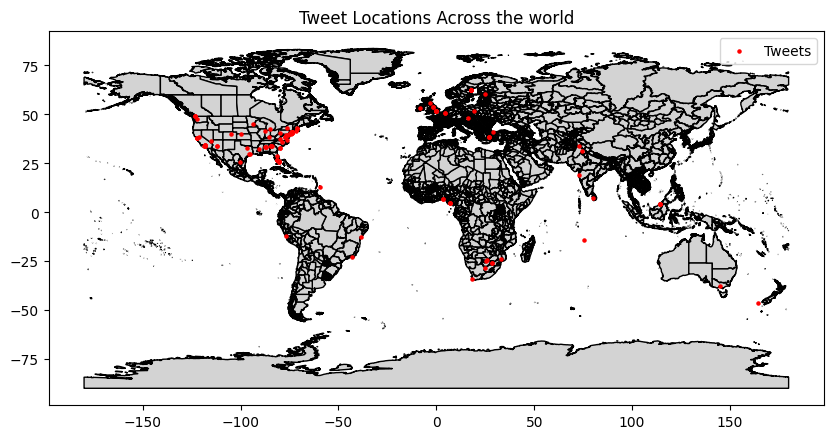

In [11]:
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Filter for rows where the 'coordinates' column is not null
tweets_with_coords = interesting_tweets[interesting_tweets["coordinates"].notnull()]

tweets_with_coords['coordinates'] = tweets_with_coords['coordinates'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Now, apply the function to extract the coordinates as a set
tweets_with_coords['coordinates_set'] = tweets_with_coords['coordinates'].apply(
    lambda x: (x['coordinates'][0], x['coordinates'][1]) if isinstance(x, dict) else None
)
#---

# Check the first few rows to ensure coordinates are correctly extracted
print(tweets_with_coords["coordinates_set"].head())

# Create the GeoDataFrame with geometry (Point objects)
geometry = tweets_with_coords["coordinates_set"].apply(lambda coord: Point(coord[0], coord[1]) if coord else None)
gdf_tweets = gpd.GeoDataFrame(tweets_with_coords, geometry=geometry)

# Check if GeoDataFrame was created successfully
print(gdf_tweets.head())

# Load a basemap of US (using shapefile for US states)
us_states = gpd.read_file("tl_2024_us_state/tl_2024_us_state.shp")
# Load the built-in Natural Earth world map dataset
world = gpd.read_file("ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")

# Plotting the world map
fig, ax = plt.subplots(figsize=(10, 8))
world.plot(ax=ax, color='lightgray', edgecolor='black')
gdf_tweets.plot(ax=ax, color="red", markersize=5, label="Tweets")  # Plot tweets


plt.title("Tweet Locations Across the world")
plt.legend()
plt.show()

# # Plotting the map
# fig, ax = plt.subplots(figsize=(10, 8))
# us_states.plot(ax=ax, color="lightgray", edgecolor="black")  # Plot US states
# gdf_tweets.plot(ax=ax, color="red", markersize=5, label="Tweets")  # Plot tweets

# plt.title("Tweet Locations Across the US")
# plt.legend()
# plt.show()



Aspect 'Hillary' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Hillary' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Trump' not found in the sentence.
Aspect 'Hillar

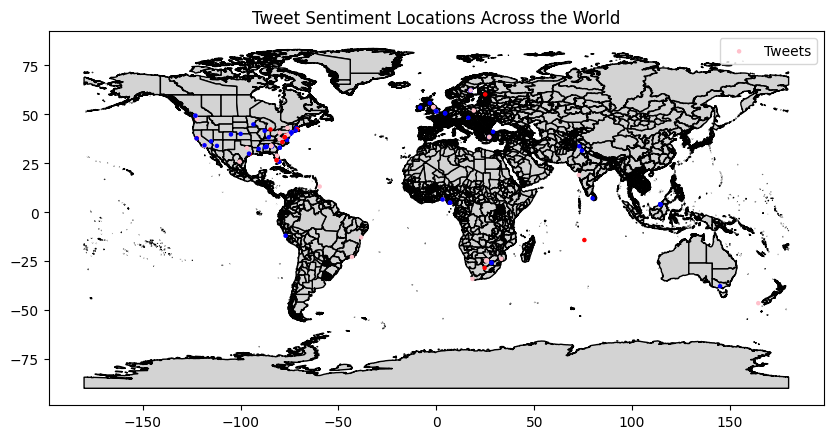

In [32]:
import geopandas as gpd
import ast
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Define a function to assign color based on sentiment results
def assign_color(sentiment_results):
    hillary_sentiment = sentiment_results.get("Hillary", {"positive": 0, "neutral": 0, "negative": 0})
    trump_sentiment = sentiment_results.get("Trump", {"positive": 0, "neutral": 0, "negative": 0})

    # Determine the dominant sentiment for each aspect
    hillary = max(hillary_sentiment, key=hillary_sentiment.get)
    trump = max(trump_sentiment, key=trump_sentiment.get)

    # Assign colors based on the rules
    if hillary == "positive":
        if trump == "negative":
            return "blue"
        elif trump == "neutral":
            return "blue"
        elif trump == "positive":
            return "pink"
    elif hillary == "neutral":
        if trump == "negative":
            return "pink"
        elif trump == "neutral":
            return "pink"
        elif trump == "positive":
            return "red"
    elif hillary == "negative":
        if trump == "negative":
            return "pink"
        elif trump == "neutral":
            return "red"
        elif trump == "positive":
            return "red"
    return "black"  # Default color if no match

# Analyze sentiment and assign colors to tweets
tweets_with_coords["sentiment_results"] = tweets_with_coords["cleaned_text"].apply(
    lambda text: analyze_aspects_sentiment_for_map(text, ["Hillary", "Trump"], absa_tokenizer, absa_model, sentiment_model)
)
tweets_with_coords["color"] = tweets_with_coords["sentiment_results"].apply(assign_color)

# Create the GeoDataFrame with geometry (Point objects)
geometry = tweets_with_coords["coordinates_set"].apply(lambda coord: Point(coord[0], coord[1]) if coord else None)
gdf_tweets = gpd.GeoDataFrame(tweets_with_coords, geometry=geometry)

# Load the world map
world = gpd.read_file("ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")

# Plotting the world map
fig, ax = plt.subplots(figsize=(10, 8))
world.plot(ax=ax, color="lightgray", edgecolor="black")

# Plot tweets with assigned colors
gdf_tweets.plot(ax=ax, color=gdf_tweets["color"], markersize=5, label="Tweets")

plt.title("Tweet Sentiment Locations Across the World")
plt.legend()
plt.show()


# Manuellt skapa ett dataset att jämföra med

Manuellt fixa en databas med x antal tweets och sätta trump sentiment och hillary sentiment som antingen positive, negative, eller neutral. Detta för att ha något att jämföra med.

In [30]:
import csv

# Path to the CSV file
file_path = "./truth_labels.csv"  # Ensure the path is correct

# Define keywords and aspect categories
all_keywords = ["trump", "hillary", "clinton"]
aspect_categories = {
    "Trump": ["trump"],
    "Clinton": ["hillary", "clinton"]
}

# Initialize counters
correct_count = 0
incorrect_count = 0
incorrect_hillary = 0
incorrect_trump = 0

# Open and read the CSV file
try:
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        # Use ';' as the delimiter
        csvreader = csv.reader(csvfile, delimiter=';')
        
        # Skip the header if it exists
        header = next(csvreader, None)
        print(f"Header: {header}")
        
        # Counter to track processed rows
        row_count = 0
        
        for row in csvreader:
            if row_count >= 500:
                break  # Limit processing to the first 500 rows
            
            # Check if the row has at least 3 columns
            if len(row) < 3:
                continue  # Skip incomplete rows
            
            # Simulate a tweet for analysis
            tweet_text = row[0]  # Column A: Tweet text
            
            # Analyze sentiment for the tweet
            sentiment_results_tweets = analyze_aspects_sentiment(
                tweet_text, all_keywords, absa_tokenizer, absa_model, sentiment_model
            )
            consolidated_results = {}
            
            # Process sentiment results for grouped aspects
            for category, related_aspects in aspect_categories.items():
                max_sentiment = {"label": "neutral", "value": 0.0}  # Default to neutral
                for aspect in related_aspects:
                    if aspect in sentiment_results_tweets:
                        # Get the highest sentiment label and value for this aspect
                        aspect_results = sentiment_results_tweets[aspect]
                        max_label = max(aspect_results, key=aspect_results.get)
                        max_value = aspect_results[max_label]
                        
                        # Update category result if this aspect has a stronger sentiment
                        if max_value > max_sentiment["value"]:
                            max_sentiment = {"label": max_label, "value": max_value}
                
                # Add result to consolidated results
                consolidated_results[category] = max_sentiment
            
            # Get the strongest sentiment labels for Hillary and Trump
            hillary_sentiment = consolidated_results.get("Clinton", {"label": "neutral"})["label"]
            trump_sentiment = consolidated_results.get("Trump", {"label": "neutral"})["label"]
            # print("Hillary: ", hillary_sentiment," Trump: ", trump_sentiment)
            # Ground truth labels
            ground_truth_hillary = row[1].strip().lower()  # Column B: Hillary sentiment
            ground_truth_trump = row[2].strip().lower()  # Column C: Trump sentiment
            # print("H_Truth: ", ground_truth_hillary," T_Truth: ", ground_truth_trump)
            # print("-------------------------------")
            # Check correctness
            if hillary_sentiment == ground_truth_hillary and trump_sentiment == ground_truth_trump:
                correct_count += 1
            elif hillary_sentiment == ground_truth_hillary and trump_sentiment != ground_truth_trump:
                incorrect_trump += 1
            elif hillary_sentiment != ground_truth_hillary and trump_sentiment == ground_truth_trump:
                incorrect_hillary += 1
            else:
                incorrect_count += 1
            
            # Increment processed row count
            row_count += 1

    # Print the final counts of correctness
    print("\nCorrect Predictions:", correct_count)
    print("Incorrect Hillary Predictions:", incorrect_hillary)
    print("Incorrect Trump Predictions:", incorrect_trump)
    print("Incorrect Predictions:", incorrect_count)

except Exception as e:
    print(f"Error loading the CSV file: {e}")


Header: ['cleaned_text', 'hillary sentiment', 'trump sentiment']

Correct Predictions: 256
Incorrect Hillary Predictions: 155
Incorrect Trump Predictions: 70
Incorrect Predictions: 19
